In [117]:
import torchvision as tv
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import enlighten
from pathlib import Path

pbar_manager = enlighten.get_manager()

In [118]:
torch.autograd.set_grad_enabled(False)

In [119]:
USE_JIT = False
path = "/home/dherrera/git/zoo_vision/models/identity/dense121_c5_identity"
if USE_JIT:
    model = torch.jit.load(path + ".ptc")
    transforms = lambda x: x
else:
    model = tv.models.densenet121(num_classes=5)
    checkpoint = torch.load(path + ".pth", weights_only=False)
    model.load_state_dict(checkpoint["model"])

    transforms = tv.models.DenseNet121_Weights.IMAGENET1K_V1.transforms(antialias=True)
model.eval()
# model = tv.models.densenet121(tv.models.DenseNet121_Weights.IMAGENET1K_V1)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [120]:
if USE_JIT:
    transforms = lambda x: x
else:
    transforms = tv.models.DenseNet121_Weights.IMAGENET1K_V1.transforms(antialias=True)
print(transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


/home/dherrera/data/elephants/identity/dataset/train/01_Chandra/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_img.jpg


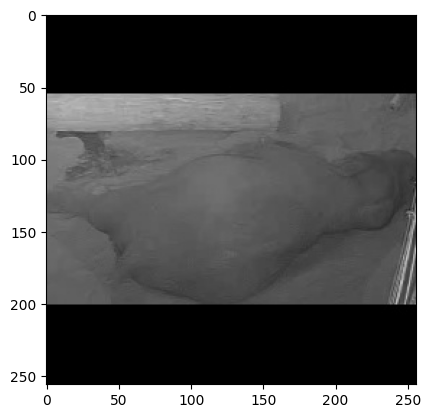

In [121]:
ds_path = Path("/home/dherrera/data/elephants/identity/dataset/train")
gt_class = "01_Chandra"

files = sorted(list((ds_path / gt_class).glob("*.jpg")))
# file = files[10]
file = Path(
    "/home/dherrera/data/elephants/identity/dataset/train/01_Chandra/ZAG-ELP-CAM-016-25.01.2025-060029-100029_00000000_img.jpg"
)
print(file)
im: np.ndarray = cv2.imread(file)
plt.imshow(im)

In [122]:
imt = transforms(torch.from_numpy(im.astype(np.float32) / 255).permute([2, 0, 1]))
imt = imt.unsqueeze(0)
result = model.forward(imt)
result

tensor([[ 1.5420, -1.0477,  1.0797, -1.8240,  0.2605]])

{'01_Chandra': 0, '02_Indi': 1, '03_Fahra': 2, '04_Panang': 3, '05_Thai': 4}


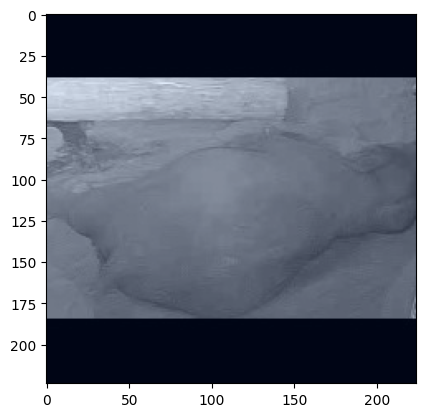

In [123]:
ds_transforms = tv.transforms.Compose([tv.transforms.PILToTensor(), transforms])
dataset_test = tv.datasets.ImageFolder(
    "/home/dherrera/data/elephants/identity/dataset/val", ds_transforms
)
print(dataset_test.class_to_idx)
ds_item, target = dataset_test[0]
if isinstance(ds_item, torch.Tensor):
    im = ds_item.permute([1, 2, 0]).numpy()
    im = im - np.mean(im)
    im = im - np.min(im)
    im = im / np.max(np.abs(im))
else:
    im = ds_item
plt.imshow(im)

In [124]:
result = model.forward(ds_item[torch.newaxis, ...])
print(result)
print(target)
print(torch.argmax(result))

tensor([[ 1.5420, -1.0477,  1.0797, -1.8240,  0.2605]])
0
tensor(0)


In [125]:
from tqdm import tqdm

total = 0
correct = 0
for i in tqdm(range(0, len(dataset_test), 100)):
    ds_item, target = dataset_test[i]
    result = model.forward(ds_item[torch.newaxis, ...])
    y = torch.argmax(result).item()

    total += 1
    if y == target:
        correct += 1
accuracy = correct / total
print(f"Accuracy: {correct}/{total}={accuracy:%}")

100%|██████████| 95/95 [00:02<00:00, 34.21it/s]

Accuracy: 94/95=98.947368%
